# Confusion Matrices

---


# Overview

---

In the [last post](https://scottminer.netlify.app/post/cross-validation/), we discussed using stratified *k*-fold cross-validation to evaluate the accuracy of an `SGDClassifier` that classifies images from the MNIST dataset as either fives or non-fives.

Confusion matrices are often better at evaluating classifiers than accuracy metrics are, especially when dealing with unbalanced datasets. Consider building a classifier that aims to predict the prevalence of a rare disease. If only 5% of the people have the disease, a classifier that always predicts healthy individuals will achieve an accuracy score of 95%. However, the classifier is relatively useless since it never predicts any instances of the disease.

 Confusion matrices provide additional metrics to investigate a classifier's performance. Before diving deeper into confusion matrices, let's look at baseline classifiers.

# Baseline Classifiers

---

In `sklearn` , baseline methods are known as dummy methods and represent the most basic estimators. Baseline methods make predictions based on simple statistics or random guesses.

`sklearn` provides four baseline classification methods. Two use _random_ strategies to make predictions, and two use _constant_ techniques.

## Random Strategies

---

* The `uniform` strategy chooses evenly amongst target classes based on the *number* of categories.
* The `stratified` technique chooses evenly amongst target classes based on the *frequency* of the groups.

The two random methods behave differently on unbalanced datasets. The `uniform` strategy picks evenly amongst classes despite the distribution of classes, whereas the `stratified` technique considers this distribution.

## Constant Strategies

---

* The `constant` strategy returns a user-defined pre-determined target class.
* The `most_frequent` technique returns the single most likely category (also available under the name `prior`).

Let's import the needed classes for this tutorial so we can take a look at a simple example of a Dummy Classifier.

# Imports

---


In [177]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import datasets
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import textwrap
import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning])

## Matplotlib & Seaborn Settings

---


In [178]:
mpl.rcParams.update({'font.size': 26})
mpl.rc('figure', figsize=(8, 8))
sns.set(font_scale=2.0)
sns.color_palette("deep")
%matplotlib inline

Now, let's build a simple dummy classifier.

# Simple DummyClassifier

---

In [179]:
# Create the features
X = np.array([-1, 1, 1, 1])

# Create the target class
y = np.array([0, 1, 1, 1])

# Create a dummy classifier using the most frequest strategy
dummy_clf = DummyClassifier(strategy="most_frequent")

# Fit the dummy classifier
dummy_clf.fit(X, y)

# Print the predictions and the score
print(f'Predictions: {dummy_clf.predict(X)}')
print(f'Score: {dummy_clf.score(X, y)}')

Predictions: [1 1 1 1]
Score: 0.75


The dummy classifier always predicts `1` 's because that is the most frequently occurring class in `y` (the target class). The dummy classifier achieved a 75% accuracy since there was a single `0` in the initial dataset.

Let's expand this example to the Iris dataset. First, we need to load the data.


# Load Iris Dataset

---


In [180]:
# Load the iris dataset
iris = datasets.load_iris()

# How many elements are in the data set?
print(f'Size of full dataset: {len(iris.data)}')

# Split the data into training and testing sets
tts_iris = train_test_split(iris.data, iris.target,
                            test_size=.33, random_state=21)

# Output the result of the train_test_split to a tuple
(iris_train_ftrs, iris_test_ftrs,
 iris_train_tgt, iris_test_tgt) = tts_iris

# The test set should contain 50 elements, since we set the size to a third
print(f'Size of test dataset: {len(iris_test_ftrs)}')

Size of full dataset: 150
Size of test dataset: 50


As you can see, `train_test_split` splits arrays into random training and test sets. The `test_size` parameter corresponds to the proportion of the dataset to include in the test split. The `random_state` parameter allows for reproducible output across multiple function calls. Let's look at a few simple examples.


## Splitting data into training and test sets

---

In [181]:
# Create 5 rows and 2 columns of features ranging from 0 - 9
# and a target variable ranging from 0 - 5
X, y = np.arange(10).reshape((5, 2)), range(5)

# Divide the data into training and testing sets
tts = train_test_split(X, y, test_size=0.33, random_state=42)

# Get the training and testing features and targets
(train_features, test_features,
 train_target,   test_target) = tts

# Print them out to verify the results
print(f'Training Features:')
print(f'{train_features}')
print(f'Training Target:')
print(f'{train_target}')
print(f'Evaluation Features:')
print(f'{test_features}')
print(f'Evaluation Target:')
print(f'{test_target}')

Training Features:
[[4 5]
 [0 1]
 [6 7]]
Training Target:
[2, 0, 3]
Evaluation Features:
[[2 3]
 [8 9]]
Evaluation Target:
[1, 4]


Setting `shuffle` to `False` specifies whether or not to shuffle the data before splitting. If `shuffle=False` , then stratify must be `None` (the default).


In [182]:
train_test_split(y, shuffle=False)

[[0, 1, 2], [3, 4]]

Let's get back to the Iris dataset.


In [183]:
print('Iris Training Features')
print('----------------------')
print(iris_train_ftrs[:10])
print()
print('Iris Training Target')
print('--------------------')
print(iris_train_tgt[:10])
print()
print('Iris Testing Features')
print('---------------------')
print(iris_test_ftrs[:10])
print()
print('Iris Testing Target')
print('---------------------')
print(iris_test_tgt[:10])

Iris Training Features
----------------------
[[6.9 3.1 4.9 1.5]
 [5.  3.3 1.4 0.2]
 [6.7 3.1 4.4 1.4]
 [7.7 2.6 6.9 2.3]
 [5.7 2.8 4.5 1.3]
 [5.8 2.7 4.1 1. ]
 [4.6 3.1 1.5 0.2]
 [5.1 3.5 1.4 0.3]
 [7.7 3.  6.1 2.3]
 [4.7 3.2 1.6 0.2]]

Iris Training Target
--------------------
[1 0 1 2 1 1 0 0 2 0]

Iris Testing Features
---------------------
[[5.8 2.6 4.  1.2]
 [5.1 3.8 1.9 0.4]
 [5.  3.4 1.5 0.2]
 [5.1 3.7 1.5 0.4]
 [5.7 3.  4.2 1.2]
 [6.6 3.  4.4 1.4]
 [5.4 3.4 1.7 0.2]
 [5.6 2.8 4.9 2. ]
 [5.  3.4 1.6 0.4]
 [5.1 3.8 1.5 0.3]]

Iris Testing Target
---------------------
[1 0 0 0 1 1 0 2 0 0]


# Iris Dataset DummyClassifier

---

What's the most frequently occurring class in the Iris dataset?

Let's look at a bar chart of the target variable. As a reminder, the target variable in the Iris dataset is the type of Iris plant (e.g., Setosa, Versicolour, or Virginica).


Class counts
------------
[[ 0 32]
 [ 1 33]
 [ 2 35]]


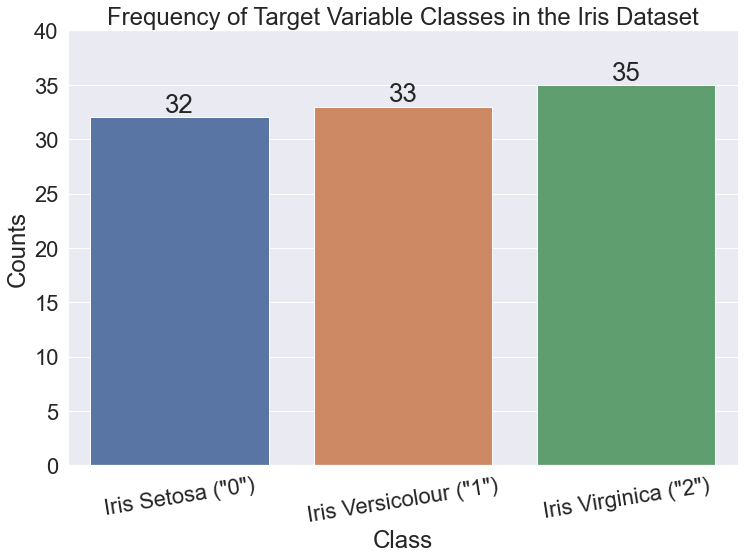

In [184]:
# Get the unique values and counts of the target variable
values, counts = np.unique(iris_train_tgt, return_counts=True)

# Print the output
print('Class counts')
print('------------')
print(np.c_[values, counts])

plt.figure(figsize=(12, 8))

# Create the bar chart
bars = sns.barplot(x=values, y=counts)

# Create the labels above the bars
plt.bar_label(bars.containers[0], label_type="edge", size=26)

# Set the titles, axes, and layout
plt.title("Frequency of Target Variable Classes in the Iris Dataset")
plt.xlabel("Class")
plt.ylabel("Counts")
labels = ['Iris Setosa ("0")', 'Iris Versicolour ("1")',
          'Iris Virginica ("2")']
plt.xticks(values, labels, rotation=9)
plt.ylim(0, 40)
plt.show()

As you can see, `2` or `Iris Virginica` is the most frequently occurring class in the Iris dataset. Supplying the `most_frequent` argument to the `strategy` parameter of the `DummyClassifier` class should return a classifier that predicts all `2` 's.


## Iris Dataset - `most_frequent` DummyClassifier

---

Let's create a baseline classifier for the Iris dataset using the `most_frequent` strategy.


In [185]:
# Create the classifier
baseline = DummyClassifier(strategy="most_frequent")

# Fit the classifier
baseline.fit(iris_train_ftrs, iris_train_tgt)

# Make predictions based on the classifier
base_preds = baseline.predict(iris_test_ftrs)

# Print to verify results
print(f'Length of baseline predictions: {len(base_preds)}')
print(f'Ten baseline predictions (they are all 2\'s): {base_preds[:10]}')

Length of baseline predictions: 50
Ten baseline predictions (they are all 2's): [2 2 2 2 2 2 2 2 2 2]


Let's check the accuracy of these predictions on the test dataset.


In [186]:
# Check the accuracy of the baseline classifier
base_acc = accuracy_score(base_preds, iris_test_tgt)
print(f'Accuracy of the baseline classifier: {base_acc}')

Accuracy of the baseline classifier: 0.3


As expected, the baseline classifier does not perform that well. Now, let's check the accuracies of all the baseline classifier strategies.

## Comparing the accuracies of all baseline strategies

---


In [187]:
# Create a list of strategies
strategies = ['constant', 'uniform', 'stratified', 'prior', 'most_frequent']

# Set up args to create different DummyClassifier strategies
baseline_args = [{'strategy': s} for s in strategies]

# Class 0 is setosa
baseline_args[0]['constant'] = 0
accuracies = []

# Loop through the classifiers and display the results in a DF
for bla in baseline_args:
    baseline = DummyClassifier(**bla)
    baseline.fit(iris_train_ftrs, iris_train_tgt)
    base_preds = baseline.predict(iris_test_ftrs)
    accuracies.append(accuracy_score(base_preds, iris_test_tgt))

display(pd.DataFrame({'accuracy': accuracies}, index=strategies))

,accuracy
constant,0.36
uniform,0.28
stratified,0.34
prior,0.30
most_frequent,0.30


The `uniform` and `stratified` strategies will return different results when re-run multiple times on a fixed train-test split because they are _randomized_ methods. The other techniques always return the same values for a fixed train-test split.

Let's do the same thing using the MNIST dataset.

# MNIST Dataset - DummyClassifier

---


In [205]:
# Read in vars from previous notebook
%store -r

# Create a list of strategies
strategies = ['constant', 'uniform', 'stratified', 'prior', 'most_frequent']

# Set up args to create different DummyClassifier strategies
baseline_args = [{'strategy': s} for s in strategies]

# False is the constant class
baseline_args[0]['constant'] = False
accuracies = []

# Loop through the classifiers and display the results in a DF
for bla in baseline_args:
    baseline = DummyClassifier(**bla)
    baseline.fit(X_train, y_train_5)
    base_preds = baseline.predict(X_test)
    accuracies.append(accuracy_score(base_preds, y_test_5))

display(pd.DataFrame({'accuracy': accuracies}, index=strategies))

,accuracy
constant,0.9108
uniform,0.4944
stratified,0.8396
prior,0.9108
most_frequent,0.9108


The `constant` , `prior` , and `most_frequent` strategies all perform the same. The accuracy is so high because only about 10% of the images in the dataset are 5s and this classifier predicts whether or not an image is a 5.

What are some of the other metrics we can use to evaluate a classifier? Let's take a look.


# Metrics Keys

---


In [189]:
print(textwrap.fill(str(sorted(metrics.SCORERS.keys())), width=70))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score',
'average_precision', 'balanced_accuracy', 'completeness_score',
'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples',
'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score',
'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples',
'jaccard_weighted', 'matthews_corrcoef', 'max_error',
'mutual_info_score', 'neg_brier_score', 'neg_log_loss',
'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error',
'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance',
'neg_mean_squared_error', 'neg_mean_squared_log_error',
'neg_median_absolute_error', 'neg_root_mean_squared_error',
'normalized_mutual_info_score', 'precision', 'precision_macro',
'precision_micro', 'precision_samples', 'precision_weighted', 'r2',
'rand_score', 'recall', 'recall_macro', 'recall_micro',
'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo',
'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted',
'top_k_accuracy', 

There certainly are a lot. How can we figure out the default scorer for a particular classifier? Let's take a look at a *k*-nearest neighbor classifier, for instance.


## Default Scorer for Classifier

---


In [190]:
knn = KNeighborsClassifier()

Returns_index = '\n'.join(knn.score.__doc__.splitlines()).index('Returns')
print('\n'.join(knn.score.__doc__.splitlines())[Returns_index:])

Returns
        -------
        score : float
            Mean accuracy of ``self.predict(X)`` wrt. `y`.
        


The above shows that the default evaluation metric for _k_-NN is mean accuracy. Let's look into confusion matrices and some other metrics, including the `precision`, `recall`, and `specificity`. 

First, we'll look at a generic confusion matrix.

# Generic Confusion Matrix

---


The below provides a sample of what hypothetical predictions returned by a binary classifier might look like, along with corresponding result labels.


In [191]:
d = {'Reality': ['0', '1', '0', '1'],
    'Prediction': ['0', '0', '1', '1'],
    'Result': ['True Negative', 'False Negative', 'False Positive', 'True Positive'],
    'Abbreviation': ['TN', 'FN', 'FP', 'TP']}

df = pd.DataFrame(data=d)
df

,Reality,Prediction,Result,Abbreviation
0,0,0,True Negative,TN
1,1,0,False Negative,FN
2,0,1,False Positive,FP
3,1,1,True Positive,TP


In a generic confusion matrix, the rows represent reality, and the columns represent predictions. However, depending on who draws the confusion matrix, the rows and columns might be flip-flopped. Let's take a look at a generic confusion matrix.

In [192]:
data = {'Predicted Negative (PredN)': ['True Negative (TN)', 'False Negative (FN)'],
        'Predicted Positive (PredP)': ['False Positive (FP)', 'True Positive (TP)']}

df = pd.DataFrame(
    data, index=['Real Negative (RealN)', 'Real Positive (RealP)'])

df

,Predicted Negative (PredN),Predicted Positive (PredP)
Real Negative (RealN),True Negative (TN),False Positive (FP)
Real Positive (RealP),False Negative (FN),True Positive (TP)


We can use the following equations to represent reality and our predictions:

$$\text{Real Negatives} = TN + FP$$
$$\text{Real Positives} = FN + TP$$
$$\text{Predicted Negatives} = TN + FN$$
$$\text{Predicted Positives} = FP + TP$$

Let's look at some additional metrics the confusion matrix provides.

# Metrics from the Confusion Matrix

---

The following provides an overview of some metrics we can calculate from a confusion matrix.

![confusion-matrix](./images-md/confusion-matrix-snippet.PNG)

## Specificity, False Positives, False Alarms, Type I Errors, and Overestimation

---

Let's start with the specificity, which we can calculate using the top row of the above confusion matrix. The specificity is also known as the _true negative rate_ (TNR). The specificity evaluates how many cases we correctly identified as false out of all the real negative cases. The best value is 1 and the worst value is 0. $$\text{specificity} = \frac{TN}{FP + TN} = \frac{TN}{RealN}$$

Another way to think about the specificity is whether or not the classifier raises a flag in the _specific_ cases we want it to. The specificity is intuitively the ability of the classifier to find all the negative samples. The specificity aims to minimize false positives. False negatives do not affect its outcome.

Two ways come to mind to calculate it in `sklearn` on a binary classifier. The first is by calculating the true negatives, etc., from the confusion matrix and performing the calculation by hand. Second, we can set the `pos_label` argument of the `recall_score` function to `0`, producing the same result. Let's look at how different predictions output differing specificities on a balanced dataset.


In [193]:
# specificity
titles = ['All False Predictions', 'Some False Positives',
          'Some False Negatives', 'Perfect Classifier']
y_true = [[0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [
    0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
y_pred = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [
    0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
for i, (y_t, y_p, title) in enumerate(zip(y_true, y_pred, titles)):
    print(f'{i + 1}. {title}')
    print('-----------------------------')
    print(f'y_true: {y_t}')
    print(f'y_pred: {y_p}')
    print()
    (tn, fp, fn, tp) = confusion_matrix(y_t, y_p).ravel()
    print(f'True Negatives: {tn}')
    print(f'False Positives: {fp}')
    print(f'True Positives: {tp}')
    print(f'False Negatives: {fn}')
    print()
    print(f'True Negative Rate 1 (Specificity): {tn / (fp + tn):.3f}')
    print(
        f'True Negative Rate 2 (Specificity): {recall_score(y_t, y_p, pos_label=0):.3f}')
    print()

1. All False Predictions
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

True Negatives: 5
False Positives: 0
True Positives: 0
False Negatives: 5

True Negative Rate 1 (Specificity): 1.000
True Negative Rate 2 (Specificity): 1.000

2. Some False Positives
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

True Negatives: 3
False Positives: 2
True Positives: 5
False Negatives: 0

True Negative Rate 1 (Specificity): 0.600
True Negative Rate 2 (Specificity): 0.600

3. Some False Negatives
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

True Negatives: 5
False Positives: 0
True Positives: 3
False Negatives: 2

True Negative Rate 1 (Specificity): 1.000
True Negative Rate 2 (Specificity): 1.000

4. Perfect Classifier
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 0, 0, 1, 1,

The specificity only decreases when we ramp up the number of false positives. As long as the classifier identifies all negative cases, the specificity will be 1.0, even if false negatives exist.

## Precision, Positive Predictive Value (PPV)

---

Traveling clockwise around the confusion matrix, let's look at another evaluation metric, this time the _precision_. The precision answers the question, "What is the value of a hit?" and is also known as the _positive predictive value_ (PPV). The formula for the precision is the following: 

$$\text{precision} = \frac{TP}{PredP} = \frac{TP}{TP + FP}$$

The precision is appropriate when we want to minimize false positives and is a metric that quantifies the number of correct positive predictions made. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1, and the worst value is 0. We can use the `precision_score` metric of `sklearn` to calculate a classifier's precision.

In [194]:
# precision
titles = ['All False Predictions', 'Some False Positives',
          'Some False Negatives', 'Perfect Classifier']
y_true = [[0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [
    0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
y_pred = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [
    0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
for i, (y_t, y_p, title) in enumerate(zip(y_true, y_pred, titles)):
    print(f'{i + 1}. {title}')
    print('-----------------------------')
    print(f'y_true: {y_t}')
    print(f'y_pred: {y_p}')
    print()
    (tn, fp, fn, tp) = confusion_matrix(y_t, y_p).ravel()
    print(f'True Negatives: {tn}')
    print(f'False Positives: {fp}')
    print(f'True Positives: {tp}')
    print(f'False Negatives: {fn}')
    print()
    print(
        f'Positive Predictive Value (Precision): {precision_score(y_t, y_p,zero_division=False):.3f}')
    print()

1. All False Predictions
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

True Negatives: 5
False Positives: 0
True Positives: 0
False Negatives: 5

Positive Predictive Value (Precision): 0.000

2. Some False Positives
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

True Negatives: 3
False Positives: 2
True Positives: 5
False Negatives: 0

Positive Predictive Value (Precision): 0.714

3. Some False Negatives
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

True Negatives: 5
False Positives: 0
True Positives: 3
False Negatives: 2

Positive Predictive Value (Precision): 1.000

4. Perfect Classifier
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

True Negatives: 5
False Positives: 0
True Positives: 5
False Negatives: 0

Positive Predictive Value (Prec

Whereas the specificity for a classifier that predicts all negative cases was 1.0, the precision is 0. The precision increases as the true positives increase and the false positives decrease. False negatives do not affect the calculation.

## Recall, Sensitivity, and True Positive Rate (TPR)

---

Now to the bottom row of the above confusion matrix to calculate the recall. The recall is also known as the _sensitivity_ or _true positive rate_ (TPR) and is appropriate when focusing on minimizing false negatives. Imagine a classifier that predicts whether a web page results from a search engine request. The recall answers the question, "Of the valuable web page results, how many did the classifier identify or _recall_ correctly?" Another way to phrase this is, "Within real-world cases of the target class, how many did the classifier identify?" Intuitively, the recall is the classifier's ability to find all the positive samples. At last, the recall is not concerned with false positives and _minimizes_ false negatives.

$$ \text{recall} = \frac{TP}{FN + TP} = \frac{TP}{RealP}$$

## The Complement of the Recall, The False Negative Rate, Type II error, Miss, Underestimation

---

The complement to caring about the number of hits we got right is the number of real hits we got wrong, which would produce a Type II error known as a _false negative_.

$$ \text{false negative rate} = \frac{FN}{TP + FN} = \frac{FN}{RealP} $$

The false negative rate is equivalent to the following:

$$ \text{false negative rate} = 1 - \text{true positive rate} $$

In other words, we can break the target class down into two groups:

* Real positives the classifier identified correctly
* Real positives the classifier identified incorrectly
 
Using the recall and its complement, we can add up the hits we got right with the hits we got wrong, giving us all the real positive cases.

$$ \frac{TP}{TP+FN} + \frac{FN}{TP+FN} = \frac{TP+FN}{TP+FN} = 1 $$

Let's develop some intution regarding the recall and its complement.

In [195]:
# Recall and False Negative Rate
titles = ['All False Predictions', 'Some False Positives',
          'Some False Negatives', 'Perfect Classifier']
y_true = [[0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [
    0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
y_pred = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [
    0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
for i, (y_t, y_p, title) in enumerate(zip(y_true, y_pred, titles)):
    print(f'{i + 1}. {title}')
    print('-----------------------------')
    print(f'y_true: {y_t}')
    print(f'y_pred: {y_p}')
    print()
    (tn, fp, fn, tp) = confusion_matrix(y_t, y_p).ravel()
    print(f'True Negatives: {tn}')
    print(f'False Positives: {fp}')
    print(f'True Positives: {tp}')
    print(f'False Negatives: {fn}')
    print()
    print(f'True Positive Rate (Recall): {recall_score(y_t, y_p):.3f}')
    print(
        f'False Negative Rate (Miss Rate): {fn / (tp + fn):.3f}')
    print()

1. All False Predictions
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

True Negatives: 5
False Positives: 0
True Positives: 0
False Negatives: 5

True Positive Rate (Recall): 0.000
False Negative Rate (Miss Rate): 1.000

2. Some False Positives
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

True Negatives: 3
False Positives: 2
True Positives: 5
False Negatives: 0

True Positive Rate (Recall): 1.000
False Negative Rate (Miss Rate): 0.000

3. Some False Negatives
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

True Negatives: 5
False Positives: 0
True Positives: 3
False Negatives: 2

True Positive Rate (Recall): 0.600
False Negative Rate (Miss Rate): 0.400

4. Perfect Classifier
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

True Negatives: 5
F

# Coding the Confusion Matrix

---

Let's code several confusion matrics for fictitious classifiers and calculate the metrics defined above for each. We use a `seaborn` `heatmap` to visualize the confusion matrices.


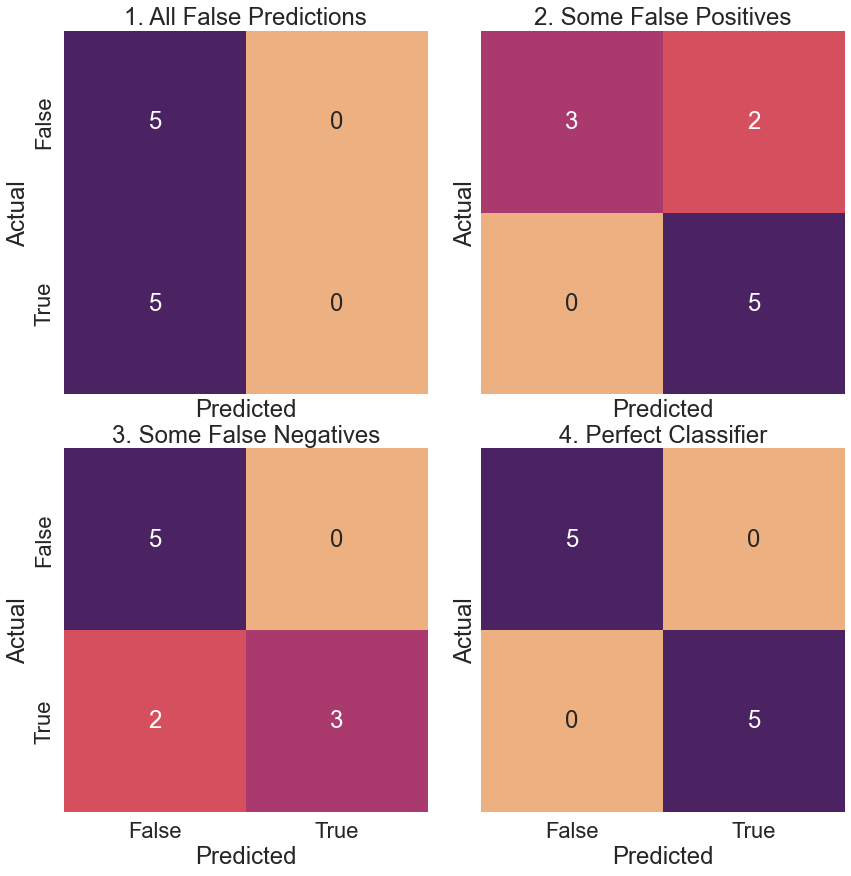

1. All False Predictions
-----------------------------
True Negatives: 5
False Positives: 0
True Positives: 0
False Negatives: 5

True Negative Rate (Specificity): 1.000
Positive Predictive Value (Precision): 0.000

True Positive Rate (Recall): 0.000
False Negative Rate (Recall Complement): 1.000

Accuracy: 0.500

2. Some False Positives
-----------------------------
True Negatives: 3
False Positives: 2
True Positives: 5
False Negatives: 0

True Negative Rate (Specificity): 0.600
Positive Predictive Value (Precision): 0.714

True Positive Rate (Recall): 1.000
False Negative Rate (Recall Complement): 0.000

Accuracy: 0.800

3. Some False Negatives
-----------------------------
True Negatives: 5
False Positives: 0
True Positives: 3
False Negatives: 2

True Negative Rate (Specificity): 1.000
Positive Predictive Value (Precision): 1.000

True Positive Rate (Recall): 0.600
False Negative Rate (Recall Complement): 0.400

Accuracy: 0.800

4. Perfect Classifier
-----------------------------
Tr

In [196]:
titles = ['All False Predictions', 'Some False Positives',
          'Some False Negatives', 'Perfect Classifier']
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
fig.tight_layout()
y_true = [[0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [
    0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
y_pred = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [
    0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]

for i, (ax, y_t, y_p, title) in enumerate(zip(axes.flat, y_true, y_pred, titles)):
    cm = confusion_matrix(y_t, y_p)
    sns.heatmap(cm, annot=True, square=True,
                xticklabels=['False', 'True'],
                yticklabels=['False', 'True'],
                fmt='g', cmap='flare', ax=ax, cbar=False, annot_kws={"size": 24})
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{i + 1}. {title}')
plt.show()

for i, (y_t, y_p, title) in enumerate(zip(y_true, y_pred, titles)):
    print(f'{i + 1}. {title}')
    print('-----------------------------')
    (tn, fp, fn, tp) = confusion_matrix(y_t, y_p).ravel()
    print(f'True Negatives: {tn}')
    print(f'False Positives: {fp}')
    print(f'True Positives: {tp}')
    print(f'False Negatives: {fn}')
    print()
    print(
        f'True Negative Rate (Specificity): {recall_score(y_t, y_p, pos_label=0):.3f}')
    print(
        f'Positive Predictive Value (Precision): {precision_score(y_t, y_p, zero_division=False):.3f}')
    print()
    print(
        f'True Positive Rate (Recall): {recall_score(y_t, y_p, zero_division=False):.3f}')
    fnr = fn/(tp + fn)
    print(f'False Negative Rate (Recall Complement): {fnr:.3f}')
    print()
    # Overall accuracy
    print(f'Accuracy: {accuracy_score(y_t, y_p):.3f}')
    print()


False positives affect the TNR (specificity) and the Positive Predictive Value (precision). False negatives, on the other hand, affect the true positive and false negative rates, otherwise known as the recall and its complement.

Let's move on to evaluating the `SGDClassifier` we built for the MNIST dataset that classifies images as either fives or not fives.

# MNIST Dataset

---

To compute a confusion matrix, we need to obtain a set of predictions on the training data. We use the training data to obtain predictions since we should only use the evaluation split for final evaluations. We can use the `cross_val_predict` method from `sklearn` to get the predictions for the `sgd_clf` we created.


In [197]:
%store -r sgd_clf
%store -r X_train
%store -r y_train_5

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

`y_train_pred` contains an array of true and false values, indicating whether or not the classifier predicts a given sample to be a five.

In [198]:
y_train_pred[:10]

array([False, False, False, False, False, False, False, False,  True,
       False])

Let's build the confusion matrix.

In [199]:
confusion_matrix(y_train_5, y_train_pred)

array([[53124,  1455],
       [  949,  4472]], dtype=int64)

We can use the `seaborn` package to make the confusion matrix easier to read.

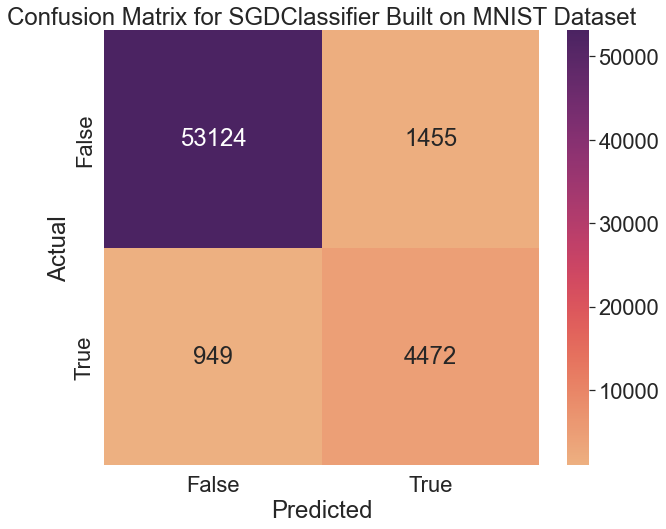

In [200]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cm = confusion_matrix(y_train_5, y_train_pred)
ax = sns.heatmap(cm, annot=True, square=True, xticklabels=[
                 'False', 'True'], yticklabels=['False', 'True'],
                 fmt='g', cmap="flare", annot_kws={"size": 24})
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix for SGDClassifier Built on MNIST Dataset')
plt.show()

The classifier correctly identified 53,124 images as non-fives (_true negatives_). The remaining 1,455 were wrongly classified as fives (_false positives_). The second row reveals that 949 real fives were incorrectly classified as non-fives (_false negatives_), while the remaining 4,472 were correctly classified as fives (_true positives_).

Let's calculate the remaining metrics.

In [201]:
tn, fp, fn, tp = confusion_matrix(
    y_true=y_train_5, y_pred=y_train_pred).ravel()

print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'True Positives: {tp}')
print(f'False Negatives: {fn}')
print()
print(
    f'True Negative Rate (Specificity): {recall_score(y_train_5, y_train_pred, pos_label=0):.3f}')
print(
    f'Positive Predictive Value (Precision): {precision_score(y_train_5, y_train_pred, zero_division=False):.3f}')
print()
print(
    f'True Positive Rate (Recall): {recall_score(y_train_5, y_train_pred, zero_division=False):.3f}')
fnr = fn/(tp + fn)
print(f'False Negative Rate (Recall Complement): {fnr:.3f}')
print()
# Overall accuracy
print(f'Accuracy: {accuracy_score(y_train_5, y_train_pred):.3f}')
print()

True Negatives: 53124
False Positives: 1455
True Positives: 4472
False Negatives: 949

True Negative Rate (Specificity): 0.973
Positive Predictive Value (Precision): 0.755

True Positive Rate (Recall): 0.825
False Negative Rate (Recall Complement): 0.175

Accuracy: 0.960



The precision indicates that when the classifier picks a five, it is right about 75.5% of the time. The recall demonstrates that the classifier detects 82.5% of the 5s. Let's compare this with a baseline classifier, using a different technique to create the classifier.

# Baseline Classifier on MNIST Dataset

---

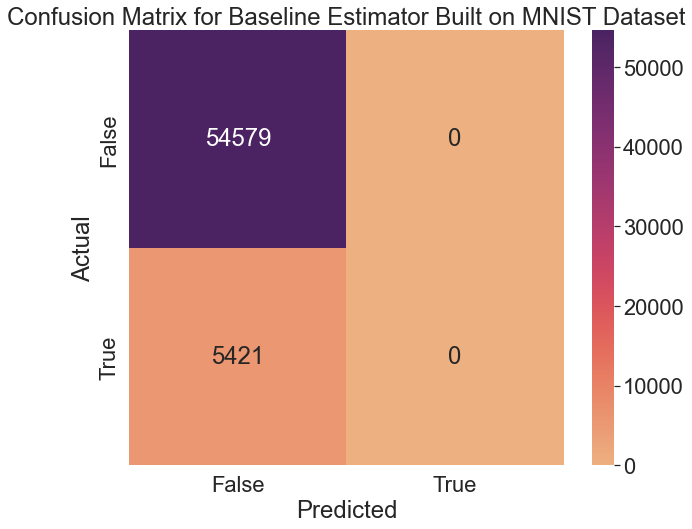

In [202]:
# Create the class
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

# Instantiate and create predictions
never_5_clf = Never5Classifier()
y_train_never_5_pred = cross_val_predict(never_5_clf, X_train, y_train_5, cv=3)

# Draw the confusion matrix 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cm = confusion_matrix(y_train_5, y_train_never_5_pred)
ax = sns.heatmap(cm, annot=True, square=True, xticklabels=[
                 'False', 'True'], yticklabels=['False', 'True'],
                 fmt='g', cmap="flare", annot_kws={"size": 24})
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix for Baseline Estimator Built on MNIST Dataset')
plt.show()

We never predict any fives. Let's check the metrics.

In [203]:
# Calculate statistics
tn, fp, fn, tp = confusion_matrix(
    y_true=y_train_5, y_pred=y_train_never_5_pred).ravel()

print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'True Positives: {tp}')
print(f'False Negatives: {fn}')
print()
print(
    f'True Negative Rate (Specificity): {recall_score(y_train_5, y_train_never_5_pred, pos_label=0):.3f}')
print(
    f'Positive Predictive Value (Precision): {precision_score(y_train_5, y_train_never_5_pred, zero_division=False):.3f}')
print()
print(
    f'True Positive Rate (Recall): {recall_score(y_train_5, y_train_never_5_pred, zero_division=False):.3f}')
fnr = fn/(tp + fn)
print(f'False Negative Rate (Recall Complement): {fnr:.3f}')
print()
# Overall accuracy
print(f'Accuracy: {accuracy_score(y_train_5, y_train_never_5_pred):.3f}')
print()

True Negatives: 54579
False Positives: 0
True Positives: 0
False Negatives: 5421

True Negative Rate (Specificity): 1.000
Positive Predictive Value (Precision): 0.000

True Positive Rate (Recall): 0.000
False Negative Rate (Recall Complement): 1.000

Accuracy: 0.910



These metrics show why the accuracy can be misleading when evaluating classifiers. We'll draw confusion matrices for multi-class classification problems in the next post.